## Dependencias

In [1]:
import tensorflow as tf
import pandas as pd
from keras import models,layers,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

## Preparación de estructura de directorios y archivos

In [21]:
ruta = '/home/jose/Documentos/bd/dogs-vs-cats/train/'
dest = '/home/jose/Documentos/bd/cats_dogs_mini/'
categorias =['cat','dog']
segmentos =['train','validate','test']

In [22]:
df = pd.DataFrame({'archivo':os.listdir(ruta)})
df['tipo'] = df['archivo'].map(lambda x:'cat' if 'cat' in x else 'dog')
cats,dogs = [d.sample(n=2000).reset_index(drop=True) for _,d in df.groupby('tipo')]

In [23]:
cats['muestra'] = (cats.index)//500
dogs['muestra'] = (dogs.index)//500
cats['muestra'] = cats['muestra'].map({0:'train',1:'train',2:'validate',3:'test'})
dogs['muestra'] = dogs['muestra'].map({0:'train',1:'train',2:'validate',3:'test'})

In [26]:
os.system('rm -rf '+dest+"*")
for s in segmentos:
    os.mkdir(os.path.join(dest,s))
    for c in categorias:
        os.mkdir(os.path.join(dest,s,c))

In [27]:
cats = [[(os.path.join(ruta,a),os.path.join(dest,tipo,'cat',a)) for a in d['archivo'].tolist()] for tipo,d in cats.groupby('muestra')]
dogs = [[(os.path.join(ruta,a),os.path.join(dest,tipo,'dog',a)) for a in d['archivo'].tolist()] for tipo,d in dogs.groupby('muestra')]

In [29]:
for l in cats:
    for t in l:
        shutil.copyfile(*t)

In [30]:
for l in dogs:
    for t in l:
        shutil.copyfile(*t)

In [31]:
for root, subdirs, files in os.walk(dest):
    for d in [os.path.join(root,sd) for sd in subdirs]:
        print(d,len(os.listdir(d)))

/home/jose/Documentos/bd/cats_dogs_mini/train 2
/home/jose/Documentos/bd/cats_dogs_mini/validate 2
/home/jose/Documentos/bd/cats_dogs_mini/test 2
/home/jose/Documentos/bd/cats_dogs_mini/train/dog 1000
/home/jose/Documentos/bd/cats_dogs_mini/train/cat 1000
/home/jose/Documentos/bd/cats_dogs_mini/validate/dog 500
/home/jose/Documentos/bd/cats_dogs_mini/validate/cat 500
/home/jose/Documentos/bd/cats_dogs_mini/test/dog 500
/home/jose/Documentos/bd/cats_dogs_mini/test/cat 500


## Arquitectura de la CNN

In [32]:
modelo = models.Sequential()
modelo.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(64,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(128,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(128,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Flatten())
modelo.add(layers.Dense(512,activation='relu'))
modelo.add(layers.Dense(1,activation='sigmoid'))

In [33]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [34]:
modelo.compile(loss='binary_crossentropy',
               optimizer = optimizers.RMSprop(learning_rate=1e-4),
               metrics=['acc'])

## Preparación de datos

In [35]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

In [37]:
train = train.flow_from_directory(os.path.join(dest,'train'),
                                  target_size=(150,150),
                                  batch_size=20,
                                  class_mode='binary')

Found 2000 images belonging to 2 classes.


In [38]:
validation = test.flow_from_directory(os.path.join(dest,'validate'),
                                  target_size=(150,150),
                                  batch_size=20,
                                  class_mode='binary')

Found 1000 images belonging to 2 classes.


## Entrenar el modelo (sobreajusta)

In [158]:
history = modelo.fit(train,
                     steps_per_epoch=100,
                     epochs=30,
                     validation_data=validation,
                     validation_steps=50)

/home/jose/entornos/ins/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 25s 250ms/step - loss: 0.7012 - acc: 0.4853 - val_loss: 0.6832 - val_acc: 0.6400
Epoch 2/30
100/100 [==============================] - 24s 238ms/step - loss: 0.6785 - acc: 0.5823 - val_loss: 0.6656 - val_acc: 0.5710
Epoch 3/30
100/100 [==============================] - 24s 239ms/step - loss: 0.6439 - acc: 0.6237 - val_loss: 0.6603 - val_acc: 0.5950
Epoch 4/30
100/100 [==============================] - 24s 235ms/step - loss: 0.5988 - acc: 0.6740 - val_loss: 0.5942 - val_acc: 0.6840
Epoch 5/30
100/100 [==============================] - 24s 238ms/step - loss: 0.5655 - acc: 0.7041 - val_loss: 0.5845 - val_acc: 0.6960
Epoch 6/30
100/100 [==============================] - 24s 238ms/step - loss: 0.5274 - acc: 0.7300 - val_loss: 0.5722 - val_acc: 0.7060
Epoch 7/30
100/100 [==============================] - 24s 240ms/step - loss: 0.4972 - acc: 0.7494 - val_loss: 0.5472 - val_acc: 0.7030
Epoch 8/30
100/100 [==============================] - 2

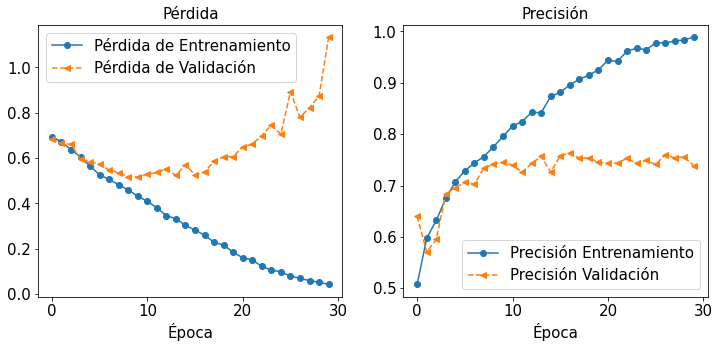

In [164]:
hist = history.history
x_arr = np.arange(len(hist['loss']))+1
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(hist['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['acc'],'-o',label='Precisión Entrenamiento')
ax.plot(hist['val_acc'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()

## Entrenamiento con data augmentation

In [39]:
train = ImageDataGenerator(rotation_range=40, #Rota las imágenes aleatoriamente
                           width_shift_range=0.2, # Traslada horizontalmente
                           height_shift_range=0.2, #Traslada verticalmente
                           shear_range=0.2, #transformaciones de corte (cizalla)
                           zoom_range=0.2, #acercamientos aleatorios
                           horizontal_flip=True, #Voltea horizontalmente
                           fill_mode='nearest' #rellena pixeles vacíos
                          )

In [46]:
gatos = [os.path.join(dest,'train','cat',x) for x in os.listdir(os.path.join(dest,'train','cat'))]
perros = [os.path.join(dest,'train','dog',x) for x in os.listdir(os.path.join(dest,'train','dog'))]

In [47]:
perros[:2]

['/home/jose/Documentos/bd/cats_dogs_mini/train/dog/dog.2974.jpg',
 '/home/jose/Documentos/bd/cats_dogs_mini/train/dog/dog.1020.jpg']

In [56]:
img = image.load_img(perros[3],target_size=(150,150))

In [57]:
x = image.img_to_array(img)

In [58]:
x = x.reshape((1,)+x.shape)

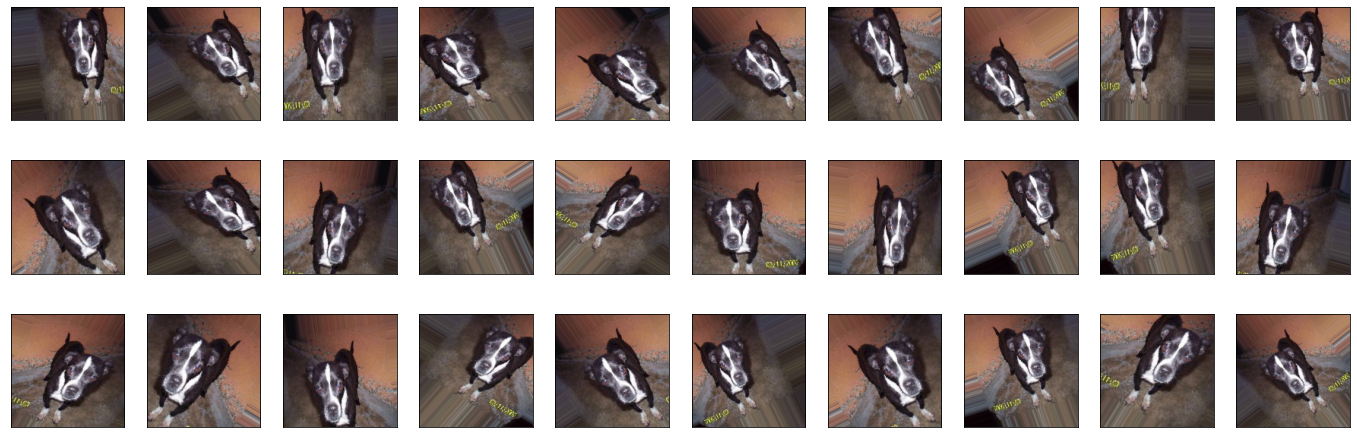

In [59]:
fig = plt.figure(figsize=(24,8))
for i,batch in enumerate(train.flow(x,batch_size=1)):
    ax = fig.add_subplot(3,10,i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image.array_to_img(batch[0]))
    if (i+1)% 30 ==0:
        break
plt.show()

## Agregar una capa Dropout para evitar el sobreajuste

In [206]:
modelo = models.Sequential()
modelo.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(64,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(128,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Conv2D(128,(3,3),activation='relu'))
modelo.add(layers.MaxPooling2D((2,2)))
modelo.add(layers.Flatten())
modelo.add(layers.Dropout(0.5))
modelo.add(layers.Dense(512,activation='relu'))
modelo.add(layers.Dense(1,activation='sigmoid'))

In [207]:
modelo.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(learning_rate=1e-4),
               metrics=['acc'])

In [208]:
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [227]:
train = ImageDataGenerator(rotation_range=40, 
                           rescale=1/255,
                           width_shift_range=0.2, 
                           height_shift_range=0.2, 
                           shear_range=0.2, 
                           zoom_range=0.2, 
                           horizontal_flip=True, 
                          )
test = ImageDataGenerator(rescale=1/255)

In [228]:
train = train.flow_from_directory(os.path.join(dest,'train'),
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='binary')

Found 2000 images belonging to 2 classes.


In [229]:
test = test.flow_from_directory(os.path.join(dest,'validate'),
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='binary')

Found 1000 images belonging to 2 classes.


In [239]:
history = modelo.fit_generator(train,
                     steps_per_epoch=2000//32,
                     epochs=100,
                     validation_data=validation,
                     validation_steps=50)

Epoch 1/100
62/62 [==============================] - 24s 380ms/step - loss: 0.4720 - acc: 0.7734 - val_loss: 0.4780 - val_acc: 0.7750
Epoch 2/100
62/62 [==============================] - 24s 380ms/step - loss: 0.4736 - acc: 0.7764 - val_loss: 0.5206 - val_acc: 0.7740
Epoch 3/100
62/62 [==============================] - 24s 386ms/step - loss: 0.4815 - acc: 0.7673 - val_loss: 0.4424 - val_acc: 0.7920
Epoch 4/100
62/62 [==============================] - 24s 387ms/step - loss: 0.4591 - acc: 0.7820 - val_loss: 0.4418 - val_acc: 0.7910
Epoch 5/100
62/62 [==============================] - 26s 416ms/step - loss: 0.4646 - acc: 0.7688 - val_loss: 0.4669 - val_acc: 0.7900
Epoch 6/100
62/62 [==============================] - 24s 392ms/step - loss: 0.4607 - acc: 0.7800 - val_loss: 0.4465 - val_acc: 0.7840
Epoch 7/100
62/62 [==============================] - 25s 399ms/step - loss: 0.4597 - acc: 0.7957 - val_loss: 0.4470 - val_acc: 0.7830
Epoch 8/100
62/62 [==============================] - 26s 411ms

Epoch 62/100
62/62 [==============================] - 24s 379ms/step - loss: 0.3765 - acc: 0.8333 - val_loss: 0.4479 - val_acc: 0.7990
Epoch 63/100
62/62 [==============================] - 24s 381ms/step - loss: 0.3812 - acc: 0.8272 - val_loss: 0.5406 - val_acc: 0.7740
Epoch 64/100
62/62 [==============================] - 24s 381ms/step - loss: 0.3627 - acc: 0.8425 - val_loss: 0.4893 - val_acc: 0.8070
Epoch 65/100
62/62 [==============================] - 24s 383ms/step - loss: 0.3701 - acc: 0.8420 - val_loss: 0.4389 - val_acc: 0.8170
Epoch 66/100
62/62 [==============================] - 24s 382ms/step - loss: 0.3725 - acc: 0.8242 - val_loss: 0.4321 - val_acc: 0.8140
Epoch 67/100
62/62 [==============================] - 24s 382ms/step - loss: 0.3958 - acc: 0.8196 - val_loss: 0.4160 - val_acc: 0.8190
Epoch 68/100
62/62 [==============================] - 24s 383ms/step - loss: 0.3695 - acc: 0.8364 - val_loss: 0.4370 - val_acc: 0.8240
Epoch 69/100
62/62 [==============================] - 2

In [240]:
modelo.save('cats_vs_dogs.h5')

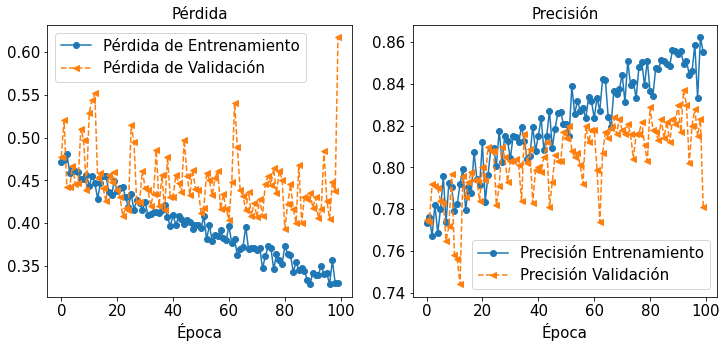

In [241]:
hist = history.history
x_arr = np.arange(len(hist['loss']))+1
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(hist['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['acc'],'-o',label='Precisión Entrenamiento')
ax.plot(hist['val_acc'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()